In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision.models.resnet import ResNet50_Weights
import lightning.pytorch as pl

from mymodels import Model_Wrapper, Preprocess
from myutils import View, sample_imgs_list

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
PATH_TO_IMAGENET = '../../datasets/imagenet/2012/'
NUM_IMG_EVAL = 10000

In [4]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50 = Model_Wrapper(resnet50)
trainer = pl.Trainer(accelerator="auto", limit_test_batches=3)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# get transforms
prep = Preprocess(PATH_TO_IMAGENET, (224, 224), shuffle=False)
preview_img_slice = slice(00000, 50000, 10000)

In [6]:
def compare_ds(model, datasets, labels, view_img_slice, view_only=False, figsize=(12,6), verbose=True, skip_results:list=[0]):
    results = {}
    samples = []
    #display first
    for ds in datasets:
        samples.append(sample_imgs_list(ds, view_img_slice))
    View.compare_color(samples, labels, figsize=figsize)
    
    if not view_only:
        for i in range(len(datasets)):
            if i in skip_results:
                continue
            result = trainer.test(model, datasets[i], verbose=verbose)
            results[labels[i]] = result
        return results
    else:
        return None
    

##### Test On Orignal Dataset

In [7]:
prep.reset_trans()
imgnet_orig = prep.get_loader()
sample_orig = sample_imgs_list(imgnet_orig, preview_img_slice)# test model on original images
result_orig = trainer.test(resnet50, imgnet_orig)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-29 18:09:30.334032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 18:09:30.468575: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-29 18:09:30.942356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-29 18:09:30.942412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     41.25485610961914     │
│    Img MEAN pixel val     │    102.51321411132812     │
│     Img STD pixel val     │     67.83306121826172     │
│        Top 1 Acc %        │          85.9375          │
│        Top 5 Acc %        │     95.57291412353516     │
└───────────────────────────┴───────────────────────────┘

##### Test on Dark Images

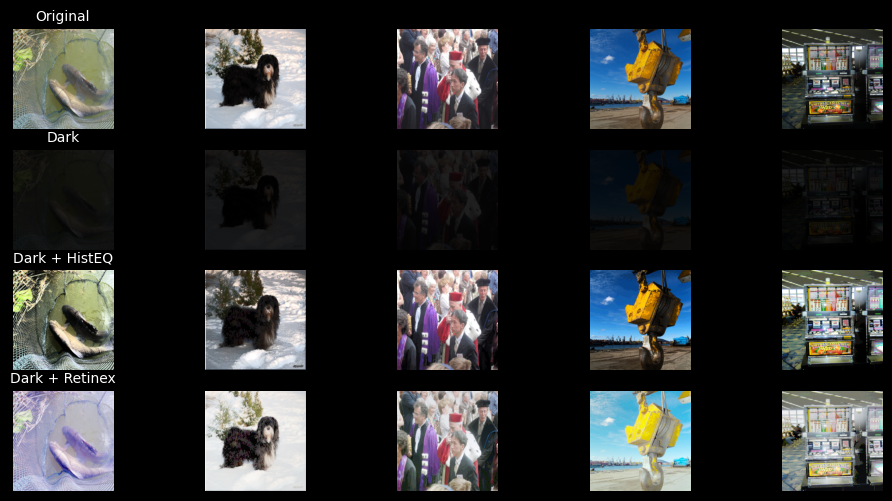

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    29.003870010375977     │
│    Img MEAN pixel val     │    12.814151763916016     │
│     Img STD pixel val     │     8.479132652282715     │
│        Top 1 Acc %        │     68.22916412353516     │
│        Top 5 Acc %        │          84.375           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     39.22854995727539     │
│    Img MEAN pixel val     │    103.79810333251953     │
│     Img STD pixel val     │     76.37516021728516     │
│        Top 1 Acc %        │     80.20833587646484     │
│        Top 5 Acc %        │     95.05208587646484     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     37.54575729370117     │
│    Img MEAN pixel val     │    154.70672607421875     │
│     Img STD pixel val     │      64.842041015625      │
│        Top 1 Acc %        │     83.33333587646484     │
│        Top 5 Acc %        │     95.57291412353516     │
└───────────────────────────┴───────────────────────────┘

In [8]:
prep.reset_trans()
imgnet_dark = prep.luminance(1/8).get_loader()
imgnet_dark_histeq = prep.copy().hist_eq().get_loader()
imgnet_dark_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_dark_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_dark, imgnet_dark_histeq, imgnet_dark_retinex],
                                 ['Original', 'Dark', 'Dark + HistEQ', 'Dark + Retinex'], 
                                 preview_img_slice)

##### Test on Bright Images

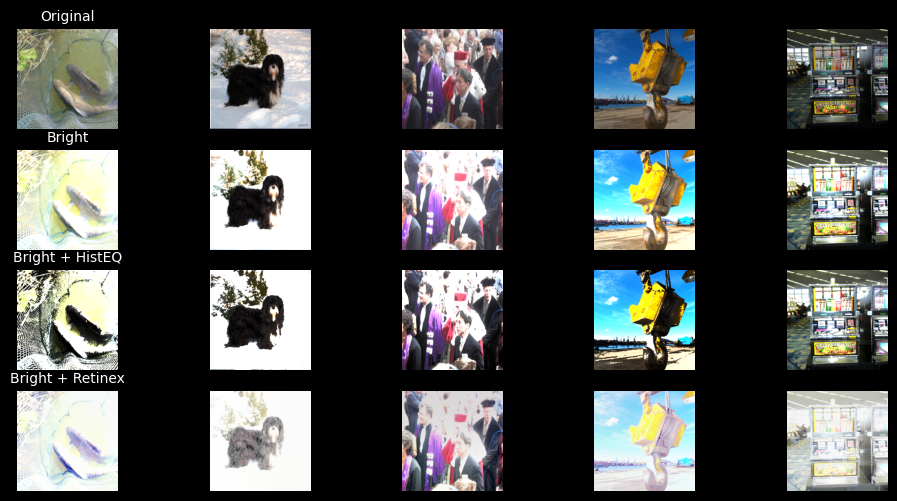

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     35.85153579711914     │
│        Top 1 Acc %        │     69.79166412353516     │
│        Top 5 Acc %        │          92.1875          │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    30.521385192871094     │
│        Top 1 Acc %        │     57.55208206176758     │
│        Top 5 Acc %        │          78.125           │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    30.867124557495117     │
│        Top 1 Acc %        │         64.84375          │
│        Top 5 Acc %        │     82.55208587646484     │
└───────────────────────────┴───────────────────────────┘

In [9]:
prep.reset_trans()
imgnet_bright = prep.luminance(2).get_loader()
imgnet_bright_histeq = prep.copy().hist_eq().get_loader()
imgnet_bright_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_bright_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_bright, imgnet_bright_histeq, imgnet_bright_retinex],
                                 ['Original', 'Bright', 'Bright + HistEQ', 'Bright + Retinex'], 
                                 preview_img_slice)

##### Test Histogram Eq on Low Contrast Images

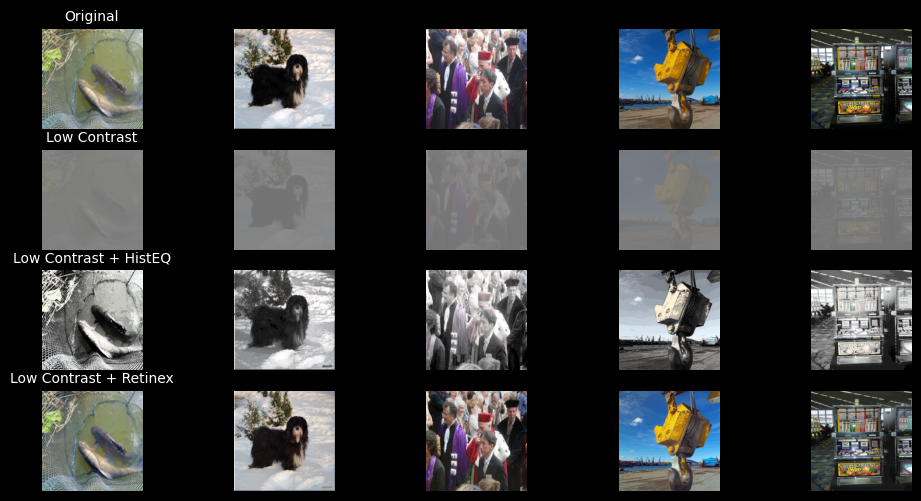

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     29.73858070373535     │
│        Top 1 Acc %        │     63.54166793823242     │
│        Top 5 Acc %        │          89.0625          │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │     30.46752166748047     │
│        Top 1 Acc %        │           62.5            │
│        Top 5 Acc %        │     84.11458587646484     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Confidence %        │    37.797664642333984     │
│        Top 1 Acc %        │     73.95833587646484     │
│        Top 5 Acc %        │         94.53125          │
└───────────────────────────┴───────────────────────────┘

In [10]:
prep.reset_trans()
imgnet_low_cont = prep.brightness_contrast(0,0.1).get_loader()
imgnet_low_cont_histeq = prep.copy().hist_eq().get_loader()
imgnet_low_cont_retinex = prep.copy().retinex('SSR', 100).get_loader()
imgnet_low_cont_results = compare_ds(resnet50, 
                                 [prep.basic_loader(), imgnet_low_cont, imgnet_low_cont_histeq, imgnet_low_cont_retinex],
                                 ['Original', 'Low Contrast', 'Low Contrast + HistEQ', 'Low Contrast + Retinex'], 
                                 preview_img_slice)

##### Test sharpening on blurry images

In [11]:
# prep.reset_trans()
# imgnet_mod = prep.blur(5).get_loader()
# imgnet_mod_filt = prep.sharpen(5).get_loader()

# sample_mod = sample_imgs(imgnet_mod, preview_img_slice)
# sample_mod_filter = sample_imgs(imgnet_mod_filt, preview_img_slice)

# View.compare3_color(sample_mod, sample_mod_filter, sample_orig)

# result_mod = trainer.test(resnet50, imgnet_mod)
# result_mod_filt = trainer.test(resnet50, imgnet_mod_filt)